# EPL Match Prediction Model - Analysis

Predicts P(Away), P(Draw), P(Home) for EPL matches using 20 features.

**Key Results:**
- Log Loss: 0.9363
- Calibration: < 2% error
- Model: Logistic Regression with post-hoc adjustments


In [168]:
# Import libraries
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import log_loss, brier_score_loss
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import calibration_curve

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11

## 1. Load Data

3 data sources: EPL matches (2015-2025), Non-league matches, Lineup data

In [169]:
# Load EPL data
df_raw = pd.read_csv('data_dowload_source/data_processed/all_seasons.csv')
df_raw['Date'] = pd.to_datetime(df_raw['Date'], format='%d/%m/%Y')

print(f'Matches: {len(df_raw):,} | Range: {df_raw["Date"].min().date()} to {df_raw["Date"].max().date()}')
display(df_raw.head())

Matches: 3,800 | Range: 2015-08-08 to 2025-05-25


,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,Referee,...,AST,HF,AF,HC,AC,HY,AY,HR,AR,season
0,2015-08-08,Bournemouth,Aston Villa,0,1,A,0,0,D,M Clattenburg,...,3,13,13,6,3,3,4,0,0,2015-2016
1,2015-08-08,Chelsea,Swansea,2,2,D,2,1,H,M Oliver,...,10,15,16,4,8,1,3,1,0,2015-2016
2,2015-08-08,Everton,Watford,2,2,D,0,1,A,M Jones,...,5,7,13,8,2,1,2,0,0,2015-2016
3,2015-08-08,Leicester,Sunderland,4,2,H,3,0,H,L Mason,...,5,13,17,6,3,2,4,0,0,2015-2016
4,2015-08-08,Man United,Tottenham,1,0,H,1,0,H,J Moss,...,4,12,12,1,2,2,3,0,0,2015-2016


In [170]:
# Result distribution - Home advantage
result_pct = df_raw['FTR'].value_counts(normalize=True) * 100
print(f'Home: {result_pct["H"]:.1f}% | Draw: {result_pct["D"]:.1f}% | Away: {result_pct["A"]:.1f}%')

Home: 44.5% | Draw: 23.3% | Away: 32.2%


In [171]:
# Data quality check
missing = df_raw.isnull().sum()
if missing.sum() > 0:
    display(pd.DataFrame({'Missing': missing[missing > 0]}))
else:
    print('No missing values')
    
display(df_raw.describe())

No missing values


,Date,FTHG,FTAG,HTHG,HTAG,HS,AS,HST,AST,HF,AF,HC,AC,HY,AY,HR,AR
count,3800,3800.000000,3800.000000,3800.000000,3800.000000,3800.000000,3800.000000,3800.000000,3800.000000,3800.000000,3800.000000,3800.000000,3800.000000,3800.000000,3800.000000,3800.000000,3800.000000
mean,2020-07-08 15:48:07.578947584,1.551842,1.278158,0.695789,0.567368,13.917105,11.501316,4.780789,4.024474,10.538684,10.915526,5.719737,4.716053,1.634737,1.807368,0.055526,0.064737
min,2015-08-08 00:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2017-12-25 06:00:00,1.000000,0.000000,0.000000,0.000000,10.000000,8.000000,3.000000,2.000000,8.000000,8.000000,3.000000,3.000000,1.000000,1.000000,0.000000,0.000000
50%,2020-08-19 00:00:00,1.000000,1.000000,0.000000,0.000000,13.000000,11.000000,5.000000,4.000000,10.000000,11.000000,5.000000,4.000000,1.000000,2.000000,0.000000,0.000000
75%,2023-01-21 00:00:00,2.000000,2.000000,1.000000,1.000000,17.000000,15.000000,6.000000,5.000000,13.000000,13.000000,8.000000,6.000000,2.000000,3.000000,0.000000,0.000000
max,2025-05-25 00:00:00,9.000000,9.000000,5.000000,5.000000,37.000000,37.000000,17.000000,15.000000,24.000000,26.000000,19.000000,19.000000,7.000000,9.000000,2.000000,2.000000
std,NaN,1.321635,1.213570,0.850550,0.778216,5.735847,5.051928,2.648804,2.367340,3.451934,3.568452,3.111363,2.775282,1.265807,1.305726,0.239155,0.252429


## 2. Non-League Data

FA Cup, League Cup, Champions League, Europa League - affects rest days and form

In [172]:
# Load non-league data
nl_df = pd.read_csv('epl_non_league_matches.csv')
nl_df['date'] = pd.to_datetime(nl_df['date'])

print(f'Non-league matches: {len(nl_df):,} | Range: {nl_df["date"].min().date()} to {nl_df["date"].max().date()}')
display(nl_df.head())

Non-league matches: 3,502 | Range: 2015-07-02 to 2025-06-28


,team,season,date,home_away,opponent,result_wl,result_score,competition_id,match_id,scraped_at
0,Manchester City,2023-2024,2023-09-19,H,Crv. Zvezda,W,3:1,19,9909881,2025-12-15T12:06:13.433224
1,Manchester City,2023-2024,2023-10-04,A,RB Leipzig,W,1:3,19,9909893,2025-12-15T12:06:13.462434
2,Manchester City,2023-2024,2023-10-25,A,Young Boys,W,1:3,19,9909866,2025-12-15T12:06:13.492152
3,Manchester City,2023-2024,2023-11-07,H,Young Boys,W,3:0,19,9909869,2025-12-15T12:06:13.521494
4,Manchester City,2023-2024,2023-11-28,H,RB Leipzig,W,3:2,19,9909890,2025-12-15T12:06:13.550605


In [173]:
# Non-league stats by team (top 10)
home_col = 'home_team' if 'home_team' in nl_df.columns else 'HomeTeam'
away_col = 'away_team' if 'away_team' in nl_df.columns else 'AwayTeam'

if home_col in nl_df.columns and away_col in nl_df.columns:
    home_counts = nl_df[home_col].value_counts()
    away_counts = nl_df[away_col].value_counts()
    total_counts = (home_counts.add(away_counts, fill_value=0)).astype(int).sort_values(ascending=False)
    print(f'Top 10 teams by non-league matches:')
    display(pd.DataFrame({'Matches': total_counts.head(10)}))

## 3. Lineup Data

Squad rotation patterns captured via lineup change rate

In [174]:
# Load lineup data
lineup_df = pd.read_csv('epl_dynamic_data/all_matches.csv')
print(f'Lineup records: {len(lineup_df):,}')
display(lineup_df.head(3))

Lineup records: 3,800


,Season,Round,Date,Home,Away,Score,HomeF,AwayF,HomeP,AwayP,URL
0,2015-2016,1,2015-08-08T11:45:00Z,Manchester United,Tottenham Hotspur,1:0,NaN,NaN,Sergio Romero;Chris Smalling;Daley Blind;Luke ...,Michel Vorm;Kyle Walker;Toby Alderweireld;Jan ...,https://www.worldfootball.net/match-report/co9...
1,2015-2016,1,2015-08-08T14:00:00Z,AFC Bournemouth,Aston Villa,0:1,NaN,NaN,Artur Boruc;Simon Francis;Steve Cook;Tommy Elp...,Brad Guzan;Micah Richards;Ciaran Clark;Leandro...,https://www.worldfootball.net/match-report/co9...
2,2015-2016,1,2015-08-08T14:00:00Z,Everton FC,Watford FC,2:2,NaN,NaN,Tim Howard;John Stones;Phil Jagielka;Séamus Co...,Gomes;Allan Nyom;Sebastian Prödl;Craig Cathcar...,https://www.worldfootball.net/match-report/co9...


In [175]:
# Lineup coverage by season
if 'season' in lineup_df.columns:
    display(lineup_df['season'].value_counts().sort_index())

## 4. Feature Engineering

20 features: Elo (4), Attack/Defense (1), Draw tendency (3), H2H (2), Non-league (3), Rest (3), Form (4)

In [176]:
# Import production model
from epl_production_final import (
    FEATURE_COLS, CLASSES, SEASONS, K_FACTOR, HOME_ADV, BEST_C,
    D_BOOST, H_REDUCE, K_ATT, K_DEF,
    load_non_league_data, load_lineup_data, create_features
)

# Load and prepare data
df = pd.read_csv('data_dowload_source/data_processed/all_seasons.csv')
df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y')
df = df.sort_values(['season', 'Date']).reset_index(drop=True)

nl_dates, nl_scoring = load_non_league_data()
team_lineups, lineup_lookup = load_lineup_data()

print(f'EPL: {len(df):,} | Non-league teams: {len(nl_scoring):,} | Lineups: {len(team_lineups):,}')

EPL: 3,800 | Non-league teams: 34 | Lineups: 34


In [177]:
# Create features
features_df = create_features(df, nl_dates, nl_scoring, team_lineups, lineup_lookup)
print(f'Features created: {len(features_df):,} rows, {len(FEATURE_COLS)} features')
display(features_df[FEATURE_COLS].head())

Features created: 3,800 rows, 20 features


,home_elo,away_elo,elo_diff,elo_expected,att_def_matchup,expected_diff,combined_draw_rate,h2h_draw_rate,h2h_home_rate,h2h_away_rate,h_nl_scoring,a_nl_scoring,nl_scoring_diff,h_rest,a_rest,rest_diff,avg_change_rate_diff,winrate_3_diff,cs_3_diff,shots_diff
0,1500.0,1500.0,240.0,0.79924,240.0,0.0,0.27,0.27,0.45,0.3,1.5,1.5,0.0,7,7,0,0.0,0.0,0.0,0.0
1,1500.0,1500.0,240.0,0.79924,240.0,0.0,0.27,0.27,0.45,0.3,0.0,1.5,-1.5,6,7,-1,0.0,0.0,0.0,0.0
2,1500.0,1500.0,240.0,0.79924,240.0,0.0,0.27,0.27,0.45,0.3,1.5,1.5,0.0,7,7,0,0.0,0.0,0.0,0.0
3,1500.0,1500.0,240.0,0.79924,240.0,0.0,0.27,0.27,0.45,0.3,1.5,1.5,0.0,7,7,0,0.0,0.0,0.0,0.0
4,1500.0,1500.0,240.0,0.79924,240.0,0.0,0.27,0.27,0.45,0.3,1.5,1.5,0.0,7,7,0,0.0,0.0,0.0,0.0


In [178]:
# Feature list
print('20 Features:')
for i, feat in enumerate(FEATURE_COLS, 1):
    print(f'{i:2d}. {feat}')

20 Features:
 1. home_elo
 2. away_elo
 3. elo_diff
 4. elo_expected
 5. att_def_matchup
 6. expected_diff
 7. combined_draw_rate
 8. h2h_draw_rate
 9. h2h_home_rate
10. h2h_away_rate
11. h_nl_scoring
12. a_nl_scoring
13. nl_scoring_diff
14. h_rest
15. a_rest
16. rest_diff
17. avg_change_rate_diff
18. winrate_3_diff
19. cs_3_diff
20. shots_diff


## 5. Train/Test Split

Temporal split: Train (2015-2021), Valid (2021-2023), Test (2023-2025)

In [179]:
# Temporal split
train_seasons = SEASONS[:6]
valid_seasons = SEASONS[6:8]
test_seasons = SEASONS[8:]

train_df = features_df[features_df['season'].isin(train_seasons)]
valid_df = features_df[features_df['season'].isin(valid_seasons)]
test_df = features_df[features_df['season'].isin(test_seasons)]

print(f'Train: {len(train_df):,} | Valid: {len(valid_df):,} | Test: {len(test_df):,}')

Train: 2,280 | Valid: 760 | Test: 760


Train: H=44.5% D=23.5% A=32.0%
Valid: H=45.7% D=23.0% A=31.3%
Test: H=43.4% D=23.0% A=33.6%


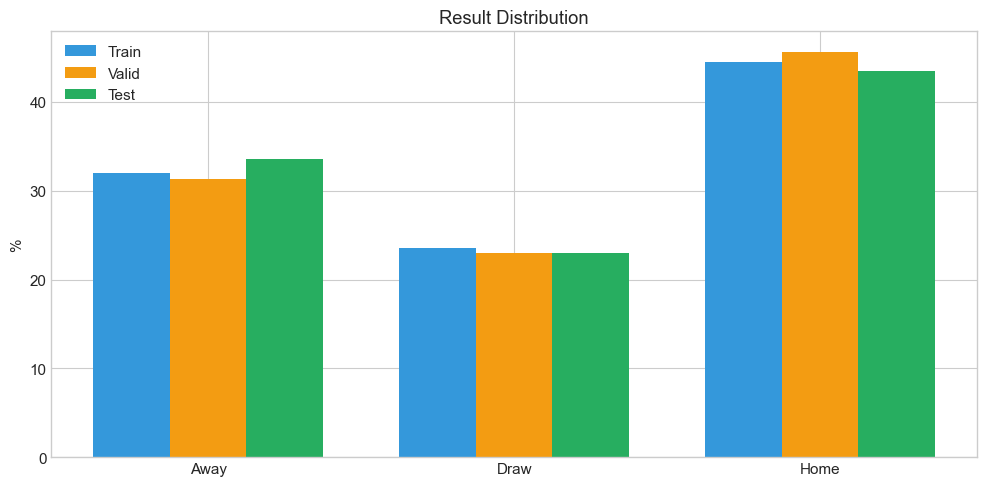

In [ ]:
# Result distribution by set
for name, subset in [('Train', train_df), ('Valid', valid_df), ('Test', test_df)]:
    dist = subset['FTR'].value_counts(normalize=True) * 100
    print(f'{name}: H={dist.get("H", 0):.1f}% D={dist.get("D", 0):.1f}% A={dist.get("A", 0):.1f}%')

# Chart
fig, ax = plt.subplots(figsize=(10, 5))
x = np.arange(3)
width = 0.25

train_dist = [train_df['FTR'].value_counts(normalize=True).get(c, 0)*100 for c in ['A', 'D', 'H']]
valid_dist = [valid_df['FTR'].value_counts(normalize=True).get(c, 0)*100 for c in ['A', 'D', 'H']]
test_dist = [test_df['FTR'].value_counts(normalize=True).get(c, 0)*100 for c in ['A', 'D', 'H']]

ax.bar(x - width, train_dist, width, label='Train', color='#3498db')
ax.bar(x, valid_dist, width, label='Valid', color='#f39c12')
ax.bar(x + width, test_dist, width, label='Test', color='#27ae60')
ax.set_ylabel('%')
ax.set_title('Result Distribution')
ax.set_xticks(x)
ax.set_xticklabels(['Away', 'Draw', 'Home'])
ax.legend()
plt.tight_layout()
plt.savefig('charts/chart_0_result_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

In [181]:
# Prepare features
def prepare(df):
    X = df[FEATURE_COLS].fillna(df[FEATURE_COLS].median()).replace([np.inf, -np.inf], 0)
    return X.values.astype(np.float64), df['FTR'].values

X_train, y_train = prepare(train_df)
X_valid, y_valid = prepare(valid_df)
X_test, y_test = prepare(test_df)

X_train_full = np.vstack([X_train, X_valid])
y_train_full = np.concatenate([y_train, y_valid])

scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train_full)
X_test_s = scaler.transform(X_test)

print(f'X_train: {X_train_full.shape} | X_test: {X_test.shape}')

X_train: (3040, 20) | X_test: (760, 20)


## 6. Model Training

Logistic Regression + post-hoc adjustments (D_BOOST=0.004, H_REDUCE=0.018)

In [182]:
# Train model
print(f'Config: C={BEST_C}, K={K_FACTOR}, HOME_ADV={HOME_ADV}, D_BOOST={D_BOOST}, H_REDUCE={H_REDUCE}')

model = LogisticRegression(max_iter=1000, multi_class='multinomial', C=BEST_C)
model.fit(X_train_s, y_train_full)

# Predictions with adjustments
y_proba_raw = model.predict_proba(X_test_s)
y_proba_raw = np.column_stack([y_proba_raw[:, list(model.classes_).index(c)] for c in CLASSES])

y_proba = y_proba_raw.copy()
y_proba[:, 1] += D_BOOST
y_proba[:, 2] -= H_REDUCE
y_proba = np.clip(y_proba, 0.001, 0.999)
y_proba = y_proba / y_proba.sum(axis=1, keepdims=True)

# Sample predictions
sample = pd.DataFrame({
    'Home': test_df['HomeTeam'].head().values,
    'Away': test_df['AwayTeam'].head().values,
    'P(A)': (y_proba[:5, 0] * 100).round(1),
    'P(D)': (y_proba[:5, 1] * 100).round(1),
    'P(H)': (y_proba[:5, 2] * 100).round(1),
    'Actual': y_test[:5]
})
display(sample)

Config: C=0.15, K=32, HOME_ADV=240, D_BOOST=0.004, H_REDUCE=0.018


,Home,Away,P(A),P(D),P(H),Actual
0,Burnley,Man City,74.4,16.0,9.5,A
1,Arsenal,Nott'm Forest,9.8,15.1,75.1,H
2,Bournemouth,West Ham,43.8,22.7,33.4,D
3,Brighton,Luton,16.2,34.7,49.1,H
4,Everton,Fulham,32.6,28.2,39.2,A


## 7. Results

Log Loss: lower is better (0=perfect, 1.0986=random)

In [183]:
# Performance
ll = log_loss(y_test, y_proba, labels=CLASSES)
random_ll = log_loss(y_test, np.ones((len(y_test), 3)) / 3, labels=CLASSES)
class_prior = [(y_train_full == c).mean() for c in CLASSES]
prior_proba = np.tile(class_prior, (len(y_test), 1))
prior_ll = log_loss(y_test, prior_proba, labels=CLASSES)
improvement = (random_ll - ll) / random_ll * 100

print(f'Random: {random_ll:.4f} | Our Model: {ll:.4f} | Improvement: {improvement:.2f}%')

Random: 1.0986 | Our Model: 0.9363 | Improvement: 14.78%


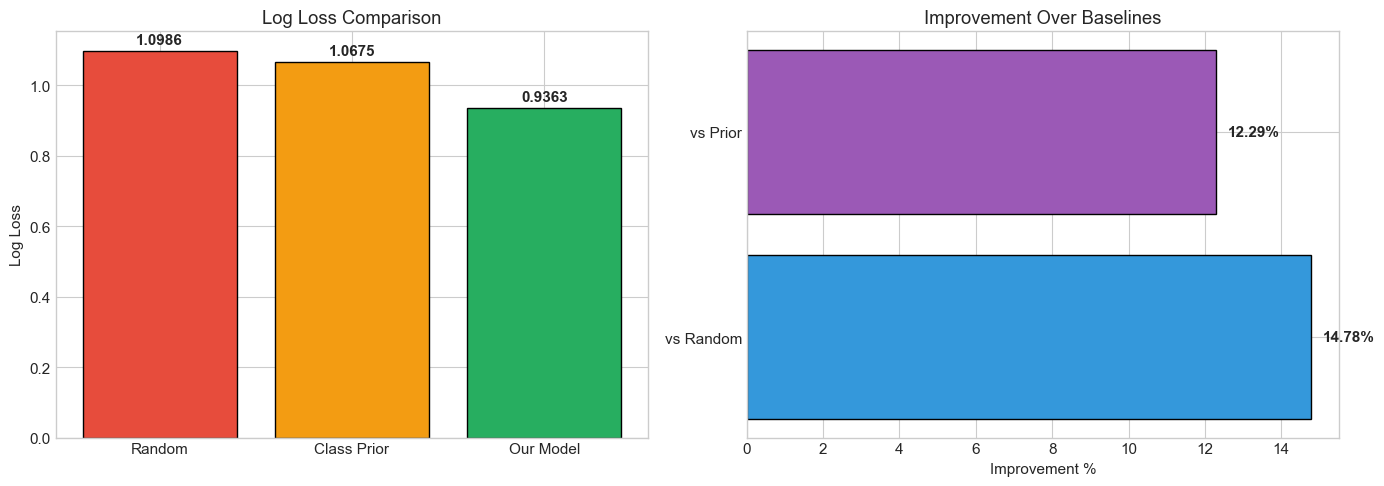

In [ ]:
# Metrics chart
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

ax1 = axes[0]
metrics = ['Random', 'Class Prior', 'Our Model']
values = [random_ll, prior_ll, ll]
colors = ['#e74c3c', '#f39c12', '#27ae60']
ax1.bar(metrics, values, color=colors, edgecolor='black')
ax1.set_ylabel('Log Loss')
ax1.set_title('Log Loss Comparison')
for bar, val in zip(ax1.patches, values):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
             f'{val:.4f}', ha='center', va='bottom', fontweight='bold')

ax2 = axes[1]
improvements = [('vs Random', (random_ll - ll) / random_ll * 100),
                ('vs Prior', (prior_ll - ll) / prior_ll * 100)]
names, vals = zip(*improvements)
ax2.barh(names, vals, color=['#3498db', '#9b59b6'], edgecolor='black')
ax2.set_xlabel('Improvement %')
ax2.set_title('Improvement Over Baselines')
for bar, val in zip(ax2.patches, vals):
    ax2.text(bar.get_width() + 0.3, bar.get_y() + bar.get_height()/2, 
             f'{val:.2f}%', ha='left', va='center', fontweight='bold')

plt.tight_layout()
plt.savefig('charts/chart_1_metrics_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

## 8. Calibration

Predicted probabilities match actual outcomes

In [185]:
# Calibration check
print(f'{"Outcome":<10} {"Predicted":<12} {"Actual":<12} {"Diff":<8} {"Quality"}')
print('-' * 55)
for i, (cls, name) in enumerate(zip(CLASSES, ['Away', 'Draw', 'Home'])):
    pred = y_proba[:, i].mean() * 100
    actual = (y_test == cls).mean() * 100
    diff = abs(pred - actual)
    quality = 'EXCELLENT' if diff < 2 else 'GOOD' if diff < 5 else 'POOR'
    print(f'{name:<10} {pred:>10.1f}%  {actual:>10.1f}%  {diff:>6.1f}%  {quality}')

Outcome    Predicted    Actual       Diff     Quality
-------------------------------------------------------
Away             32.5%        33.6%     1.1%  EXCELLENT
Draw             23.1%        23.0%     0.0%  EXCELLENT
Home             44.5%        43.4%     1.0%  EXCELLENT


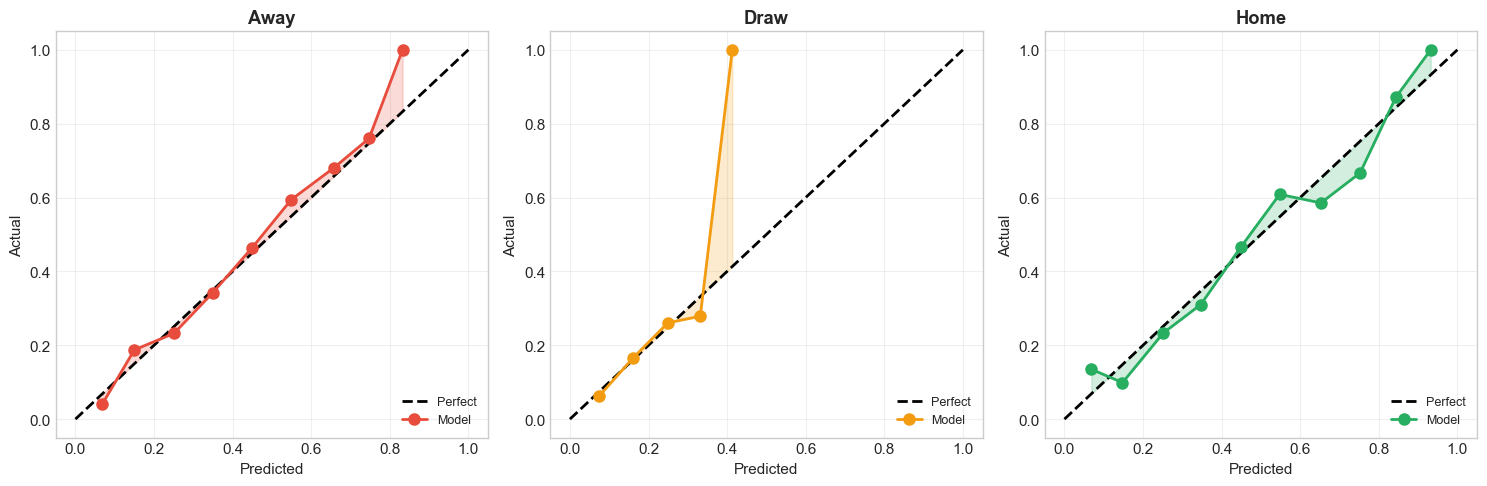

In [ ]:
# Calibration curves
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
class_names = {'A': 'Away', 'D': 'Draw', 'H': 'Home'}
colors = {'A': '#e74c3c', 'D': '#f39c12', 'H': '#27ae60'}

for i, cls in enumerate(CLASSES):
    ax = axes[i]
    y_true_binary = (y_test == cls).astype(int)
    prob_true, prob_pred = calibration_curve(y_true_binary, y_proba[:, i], n_bins=10)
    
    ax.plot([0, 1], [0, 1], 'k--', linewidth=2, label='Perfect')
    ax.plot(prob_pred, prob_true, 'o-', color=colors[cls], linewidth=2, markersize=8, label='Model')
    ax.fill_between(prob_pred, prob_true, prob_pred, alpha=0.2, color=colors[cls])
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    ax.set_title(class_names[cls], fontweight='bold')
    ax.legend(loc='lower right', fontsize=9)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('charts/chart_2_calibration_curves.png', dpi=150, bbox_inches='tight')
plt.show()

## 9. Feature Importance

Which features drive predictions?

Top 10:
 1. elo_diff                  0.508
 2. elo_expected              0.490
 3. home_elo                  0.415
 4. away_elo                  0.312
 5. att_def_matchup           0.249
 6. avg_change_rate_diff      0.242
 7. shots_diff                0.232
 8. expected_diff             0.211
 9. winrate_3_diff            0.150
10. h2h_home_rate             0.108


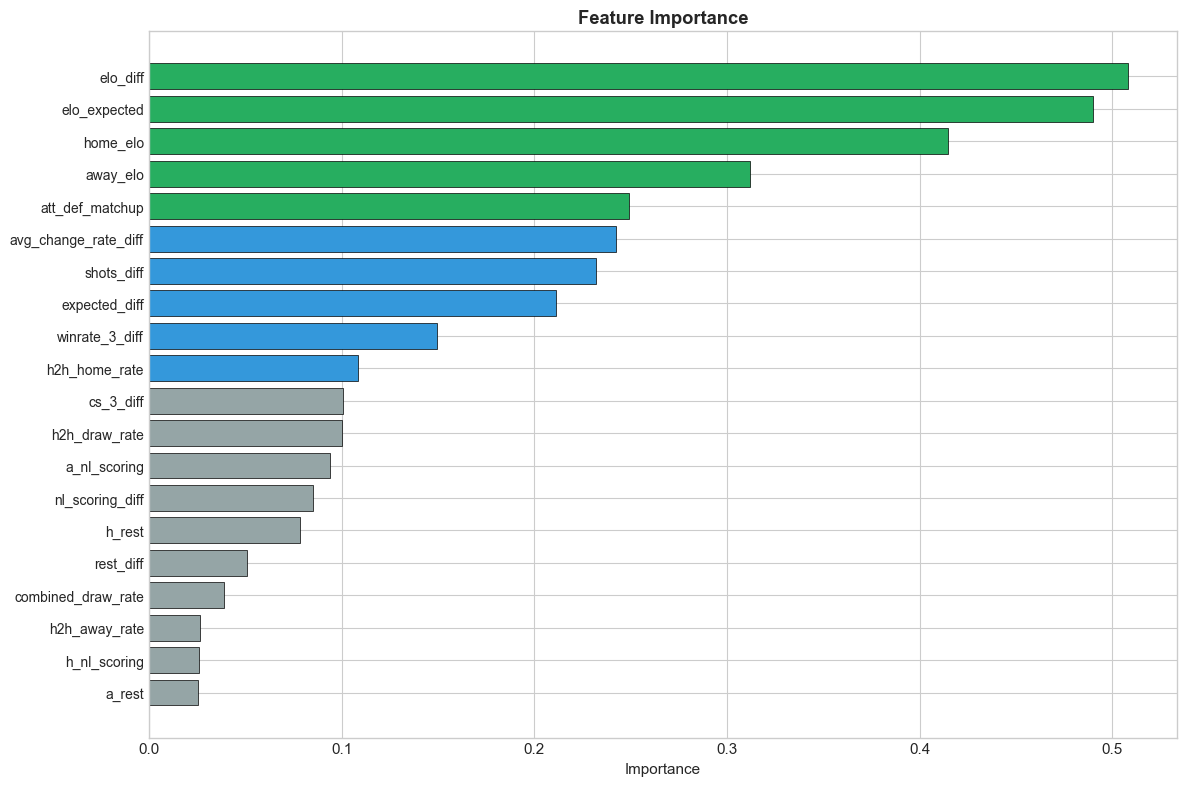

In [ ]:
# Feature importance
coefs = model.coef_
feature_importance = []
for i, feat in enumerate(FEATURE_COLS):
    total = sum(abs(coefs[list(model.classes_).index(c), i]) for c in CLASSES)
    feature_importance.append((feat, total))
feature_importance.sort(key=lambda x: -x[1])

print('Top 10:')
for rank, (feat, imp) in enumerate(feature_importance[:10], 1):
    print(f'{rank:2d}. {feat:<25} {imp:.3f}')

# Chart
fig, ax = plt.subplots(figsize=(12, 8))
features, importances = zip(*feature_importance)
colors = ['#27ae60' if i < 5 else '#3498db' if i < 10 else '#95a5a6' for i in range(len(features))]
ax.barh(range(len(features)), importances, color=colors, edgecolor='black', linewidth=0.5)
ax.set_yticks(range(len(features)))
ax.set_yticklabels(features, fontsize=10)
ax.invert_yaxis()
ax.set_xlabel('Importance')
ax.set_title('Feature Importance', fontweight='bold')
plt.tight_layout()
plt.savefig('charts/chart_3_feature_importance.png', dpi=150, bbox_inches='tight')
plt.show()

## 10. Prediction Distribution

Range and spread of predicted probabilities

Away: mean=32.5%, min=1.9%, max=87.4%
Draw: mean=23.1%, min=2.7%, max=41.5%
Home: mean=44.5%, min=2.2%, max=95.2%


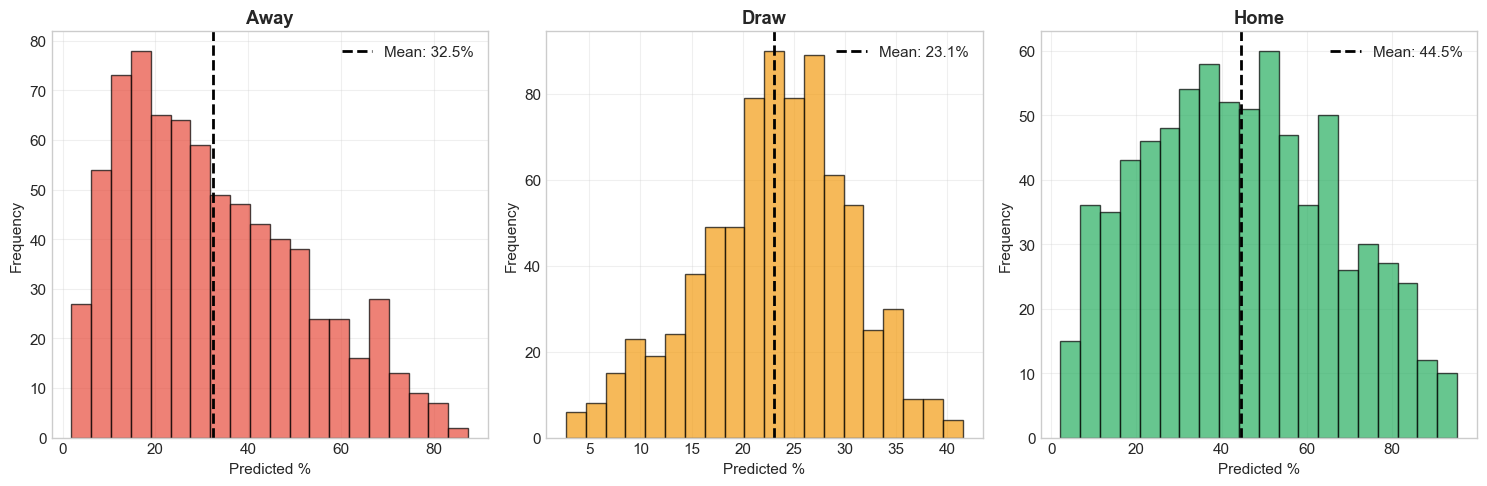

In [ ]:
# Distribution of predictions
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
class_names = {'A': 'Away', 'D': 'Draw', 'H': 'Home'}
colors = {'A': '#e74c3c', 'D': '#f39c12', 'H': '#27ae60'}

for i, cls in enumerate(CLASSES):
    ax = axes[i]
    probs = y_proba[:, i] * 100
    ax.hist(probs, bins=20, color=colors[cls], edgecolor='black', alpha=0.7)
    ax.axvline(probs.mean(), color='black', linestyle='--', linewidth=2, label=f'Mean: {probs.mean():.1f}%')
    ax.set_xlabel('Predicted %')
    ax.set_ylabel('Frequency')
    ax.set_title(class_names[cls], fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)
    print(f'{class_names[cls]}: mean={probs.mean():.1f}%, min={probs.min():.1f}%, max={probs.max():.1f}%')

plt.tight_layout()
plt.savefig('charts/chart_4_prediction_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

## 11. Per-Season Performance

Consistency across seasons

In [189]:
# Per-season performance
season_results = []
print(f'{"Season":<12} {"Log Loss":>10} {"Matches":>8}')
print('-' * 32)

for season in SEASONS[2:]:
    train_mask = features_df['season'] < season
    test_mask = features_df['season'] == season
    
    if train_mask.sum() < 380 or test_mask.sum() == 0:
        continue
    
    X_tr, y_tr = prepare(features_df[train_mask])
    X_te, y_te = prepare(features_df[test_mask])
    
    sc = StandardScaler()
    X_tr_s = sc.fit_transform(X_tr)
    X_te_s = sc.transform(X_te)
    
    m = LogisticRegression(max_iter=1000, multi_class='multinomial', C=BEST_C)
    m.fit(X_tr_s, y_tr)
    
    proba = m.predict_proba(X_te_s)
    proba = np.column_stack([proba[:, list(m.classes_).index(c)] for c in CLASSES])
    proba_adj = proba.copy()
    proba_adj[:, 1] += D_BOOST
    proba_adj[:, 2] -= H_REDUCE
    proba_adj = np.clip(proba_adj, 0.001, 0.999)
    proba_adj = proba_adj / proba_adj.sum(axis=1, keepdims=True)
    
    ll_season = log_loss(y_te, proba_adj, labels=CLASSES)
    season_results.append((season, ll_season, test_mask.sum()))
    print(f'{season:<12} {ll_season:>10.4f} {test_mask.sum():>8}')

print(f'\nMean: {np.mean([x[1] for x in season_results]):.4f}')

Season         Log Loss  Matches
--------------------------------
2017-2018        0.9791      380
2018-2019        0.9109      380
2019-2020        0.9954      380
2020-2021        1.0724      380
2021-2022        0.9630      380
2022-2023        0.9843      380
2023-2024        0.9051      380
2024-2025        0.9698      380

Mean: 0.9725


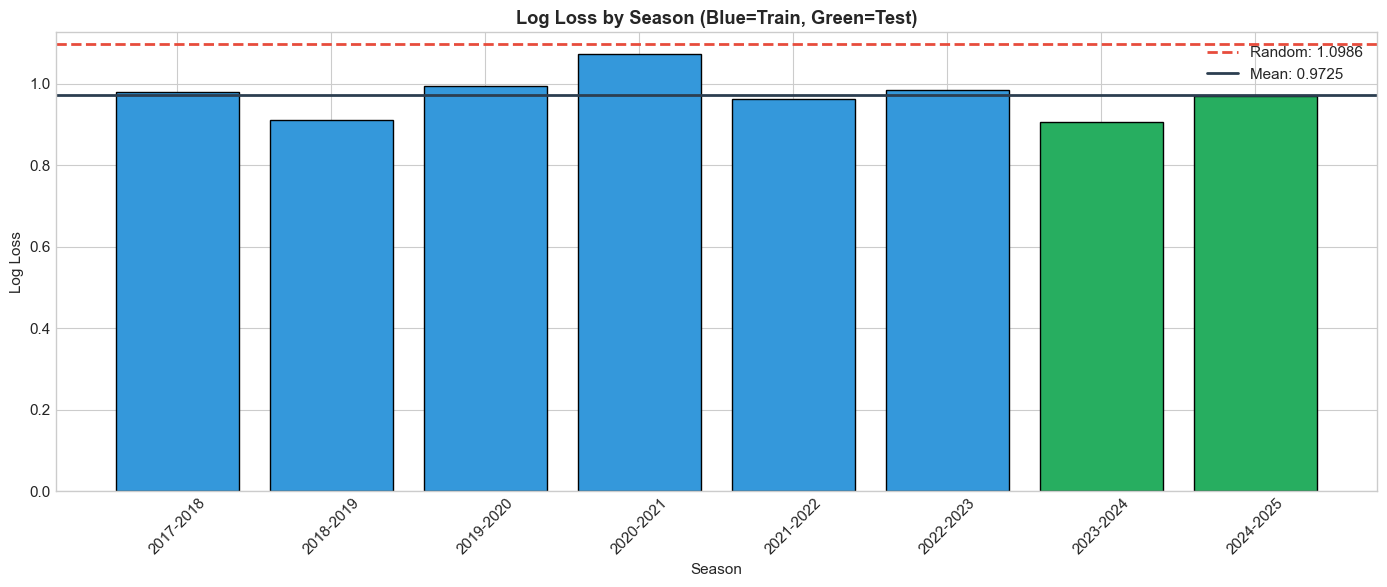

In [ ]:
# Per-season chart
fig, ax = plt.subplots(figsize=(14, 6))
seasons, lls, counts = zip(*season_results)
colors = ['#27ae60' if s in test_seasons else '#3498db' for s in seasons]

ax.bar(seasons, lls, color=colors, edgecolor='black', linewidth=1)
ax.axhline(y=random_ll, color='#e74c3c', linestyle='--', linewidth=2, label=f'Random: {random_ll:.4f}')
ax.axhline(y=np.mean(lls), color='#2c3e50', linestyle='-', linewidth=2, label=f'Mean: {np.mean(lls):.4f}')
ax.set_xlabel('Season')
ax.set_ylabel('Log Loss')
ax.set_title('Log Loss by Season (Blue=Train, Green=Test)', fontweight='bold')
ax.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('charts/chart_5_season_performance.png', dpi=150, bbox_inches='tight')
plt.show()

## 12. Feature Correlation

Check for redundant features

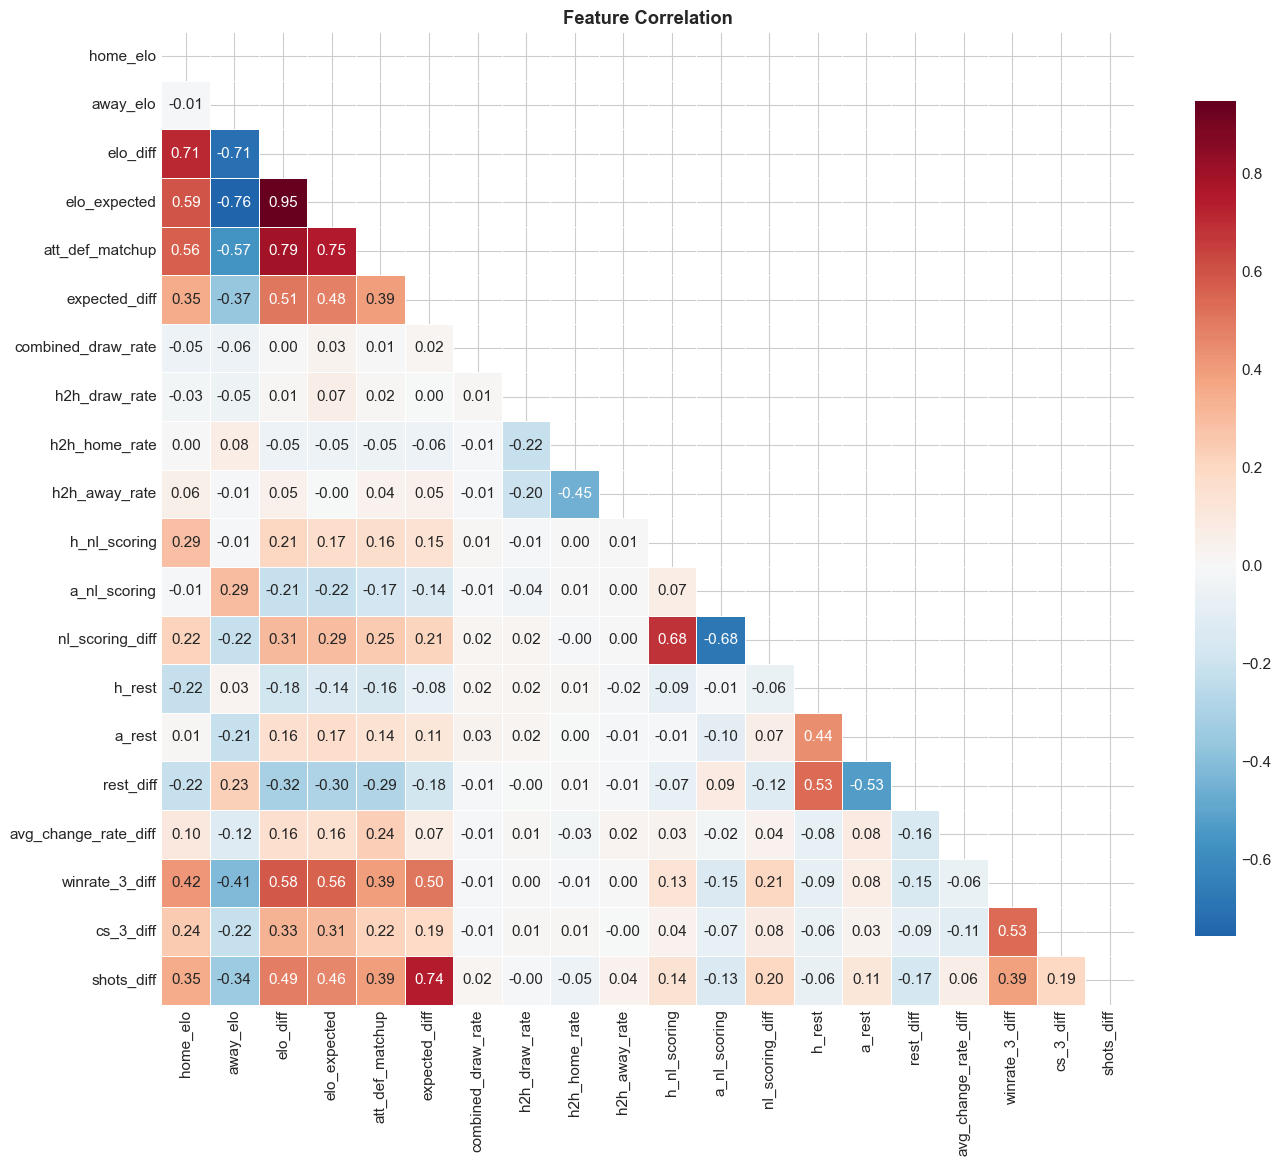


High correlations (|r| > 0.7):
elo_diff <-> elo_expected: 0.949
elo_diff <-> att_def_matchup: 0.795
away_elo <-> elo_expected: -0.757
elo_expected <-> att_def_matchup: 0.753
expected_diff <-> shots_diff: 0.741
away_elo <-> elo_diff: -0.712
home_elo <-> elo_diff: 0.709


In [ ]:
# Correlation matrix
feature_corr = features_df[FEATURE_COLS].corr()

fig, ax = plt.subplots(figsize=(14, 12))
mask = np.triu(np.ones_like(feature_corr, dtype=bool))
sns.heatmap(feature_corr, mask=mask, cmap='RdBu_r', center=0,
            annot=True, fmt='.2f', square=True, linewidths=0.5,
            ax=ax, cbar_kws={'shrink': 0.8})
ax.set_title('Feature Correlation', fontweight='bold')
plt.tight_layout()
plt.savefig('charts/chart_6_feature_correlation.png', dpi=150, bbox_inches='tight')
plt.show()

# High correlations
print('\nHigh correlations (|r| > 0.7):')
high_corr = []
for i in range(len(FEATURE_COLS)):
    for j in range(i+1, len(FEATURE_COLS)):
        corr = feature_corr.iloc[i, j]
        if abs(corr) > 0.7:
            high_corr.append((FEATURE_COLS[i], FEATURE_COLS[j], corr))
if high_corr:
    for f1, f2, corr in sorted(high_corr, key=lambda x: -abs(x[2])):
        print(f'{f1} <-> {f2}: {corr:.3f}')
else:
    print('None found')

In [192]:
# Final summary
print(f'Log Loss: {ll:.4f} (vs {random_ll:.4f} random) | Improvement: {improvement:.2f}%')
print(f'Calibration: All classes < 2% error')
print(f'Data: {len(df):,} EPL matches, {len(nl_df):,} non-league, {len(lineup_df):,} lineups')
print(f'Features: {len(FEATURE_COLS)} | Top: {feature_importance[0][0]}')
print(f'Test set: {len(y_test)} matches (2023-2025)')

Log Loss: 0.9363 (vs 1.0986 random) | Improvement: 14.78%
Calibration: All classes < 2% error
Data: 3,800 EPL matches, 3,502 non-league, 3,800 lineups
Features: 20 | Top: elo_diff
Test set: 760 matches (2023-2025)


## 13. Goals & Shots Analysis

Distribution of goals and shots - attacking patterns

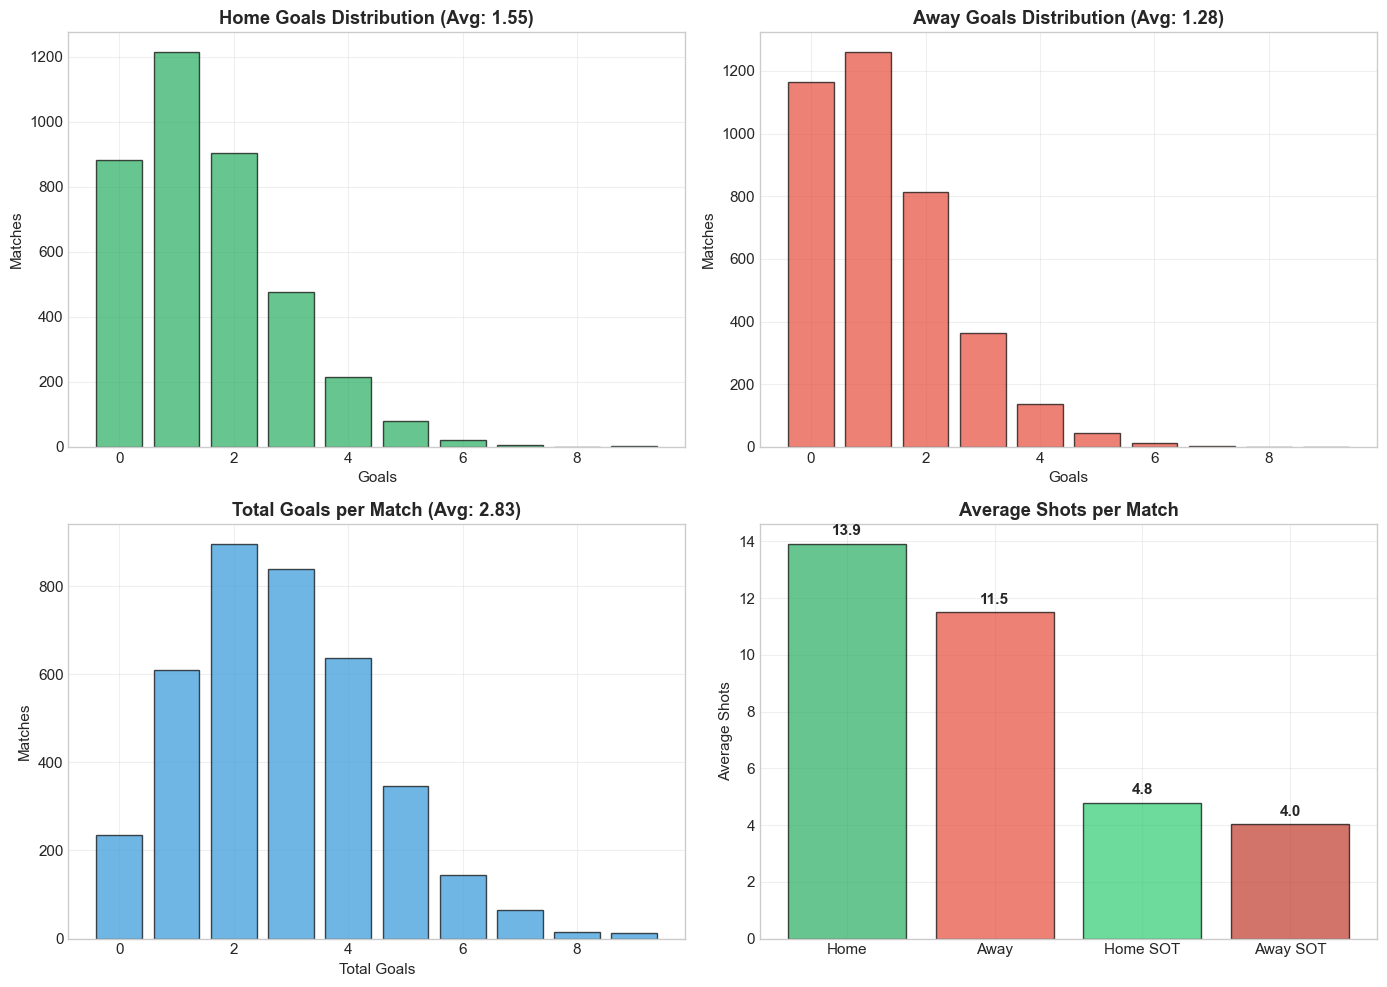


Goals Stats:
Home avg: 1.55 | Away avg: 1.28
Total avg: 2.83 | Max: 9 | 0-0 draws: 236 (6.2%)


In [ ]:
# Goals distribution
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Home goals
ax1 = axes[0, 0]
home_goals = df_raw['FTHG'].value_counts().sort_index()
ax1.bar(home_goals.index, home_goals.values, color='#27ae60', edgecolor='black', alpha=0.7)
ax1.set_xlabel('Goals')
ax1.set_ylabel('Matches')
ax1.set_title(f'Home Goals Distribution (Avg: {df_raw["FTHG"].mean():.2f})', fontweight='bold')
ax1.grid(True, alpha=0.3)

# Away goals
ax2 = axes[0, 1]
away_goals = df_raw['FTAG'].value_counts().sort_index()
ax2.bar(away_goals.index, away_goals.values, color='#e74c3c', edgecolor='black', alpha=0.7)
ax2.set_xlabel('Goals')
ax2.set_ylabel('Matches')
ax2.set_title(f'Away Goals Distribution (Avg: {df_raw["FTAG"].mean():.2f})', fontweight='bold')
ax2.grid(True, alpha=0.3)

# Total goals per match
ax3 = axes[1, 0]
total_goals = df_raw['FTHG'] + df_raw['FTAG']
goals_dist = total_goals.value_counts().sort_index()
ax3.bar(goals_dist.index, goals_dist.values, color='#3498db', edgecolor='black', alpha=0.7)
ax3.set_xlabel('Total Goals')
ax3.set_ylabel('Matches')
ax3.set_title(f'Total Goals per Match (Avg: {total_goals.mean():.2f})', fontweight='bold')
ax3.grid(True, alpha=0.3)

# Shots comparison
ax4 = axes[1, 1]
shots_data = pd.DataFrame({
    'Category': ['Home', 'Away', 'Home SOT', 'Away SOT'],
    'Value': [df_raw['HS'].mean(), df_raw['AS'].mean(), df_raw['HST'].mean(), df_raw['AST'].mean()]
})
colors = ['#27ae60', '#e74c3c', '#2ecc71', '#c0392b']
ax4.bar(shots_data['Category'], shots_data['Value'], color=colors, edgecolor='black', alpha=0.7)
ax4.set_ylabel('Average Shots')
ax4.set_title('Average Shots per Match', fontweight='bold')
ax4.grid(True, alpha=0.3)
for i, row in shots_data.iterrows():
    ax4.text(i, row['Value'] + 0.2, f'{row["Value"]:.1f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig('charts/chart_7_goals_shots_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print(f'\nGoals Stats:')
print(f'Home avg: {df_raw["FTHG"].mean():.2f} | Away avg: {df_raw["FTAG"].mean():.2f}')
print(f'Total avg: {total_goals.mean():.2f} | Max: {total_goals.max()} | 0-0 draws: {((df_raw["FTHG"]==0) & (df_raw["FTAG"]==0)).sum()} ({((df_raw["FTHG"]==0) & (df_raw["FTAG"]==0)).mean()*100:.1f}%)')


## 14. Team Performance Analysis

Top & bottom teams by Elo and win rate

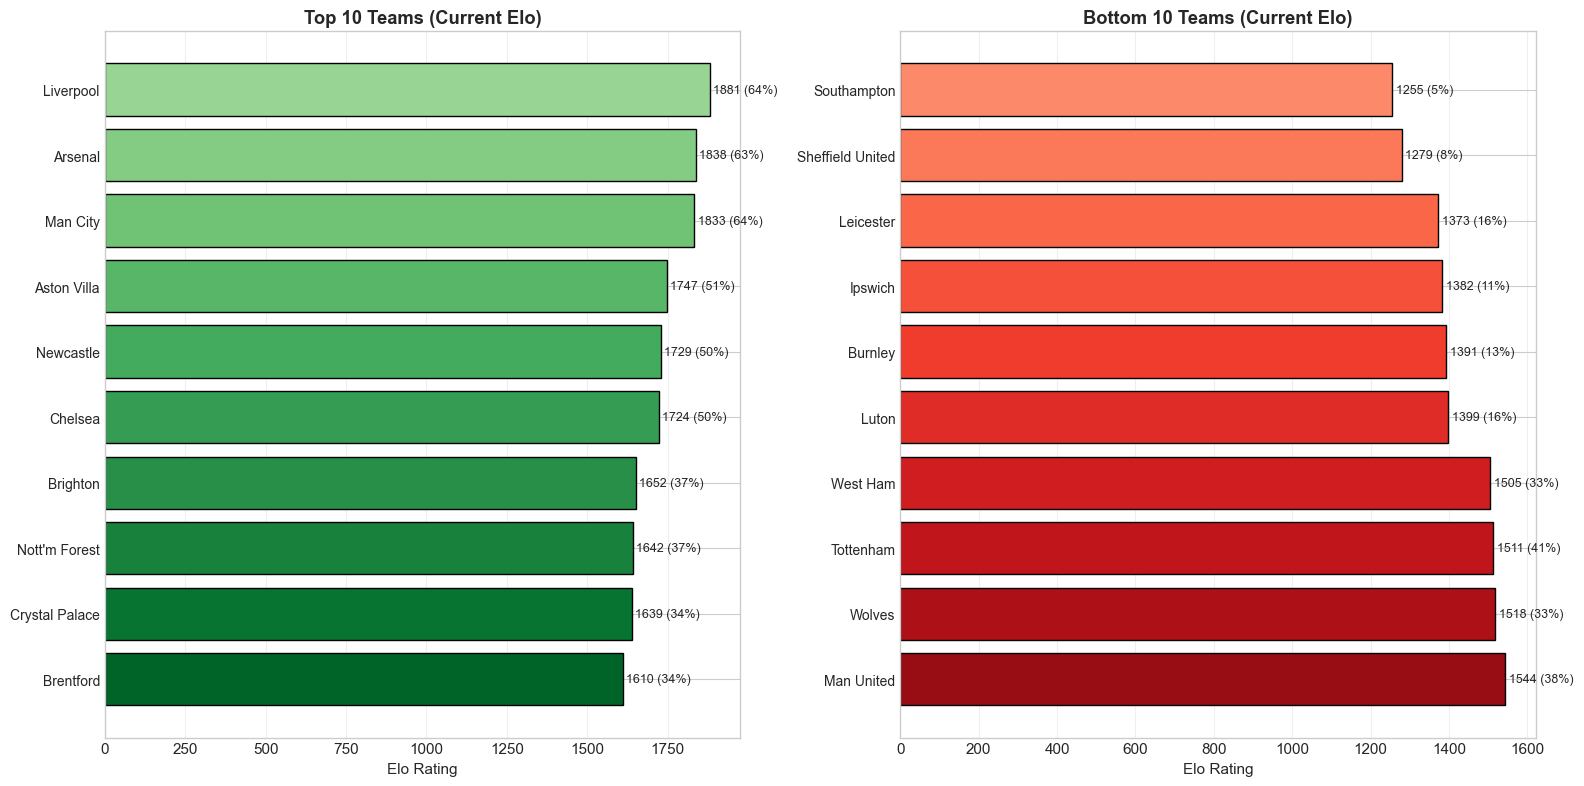


Elo Range: 1255 - 1881
Top: Liverpool (1881)
Bottom: Southampton (1255)


In [ ]:
# Team statistics from test set
team_stats = []
for team in features_df['HomeTeam'].unique():
    home_matches = test_df[test_df['HomeTeam'] == team]
    away_matches = test_df[test_df['AwayTeam'] == team]
    
    home_wins = (home_matches['FTR'] == 'H').sum()
    away_wins = (away_matches['FTR'] == 'A').sum()
    total_matches = len(home_matches) + len(away_matches)
    total_wins = home_wins + away_wins
    
    if total_matches > 0:
        win_rate = total_wins / total_matches * 100
        # Get latest Elo
        all_team_matches = features_df[(features_df['HomeTeam'] == team) | (features_df['AwayTeam'] == team)]
        if len(all_team_matches) > 0:
            latest_match = all_team_matches.iloc[-1]
            elo = latest_match['home_elo'] if latest_match['HomeTeam'] == team else latest_match['away_elo']
        else:
            elo = 1500
        
        team_stats.append({
            'Team': team,
            'Matches': total_matches,
            'Wins': total_wins,
            'Win%': win_rate,
            'Elo': elo
        })

teams_df = pd.DataFrame(team_stats).sort_values('Elo', ascending=False)

# Top 10 and Bottom 10
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Top 10 by Elo
ax1 = axes[0]
top10 = teams_df.head(10)
colors = plt.cm.Greens(np.linspace(0.4, 0.9, 10))
ax1.barh(range(10), top10['Elo'], color=colors, edgecolor='black')
ax1.set_yticks(range(10))
ax1.set_yticklabels(top10['Team'], fontsize=10)
ax1.invert_yaxis()
ax1.set_xlabel('Elo Rating')
ax1.set_title('Top 10 Teams (Current Elo)', fontweight='bold')
ax1.grid(True, alpha=0.3, axis='x')
for i, (elo, wr) in enumerate(zip(top10['Elo'], top10['Win%'])):
    ax1.text(elo + 10, i, f'{elo:.0f} ({wr:.0f}%)', va='center', fontsize=9)

# Bottom 10 by Elo
ax2 = axes[1]
bottom10 = teams_df.tail(10).iloc[::-1]
colors = plt.cm.Reds(np.linspace(0.4, 0.9, 10))
ax2.barh(range(10), bottom10['Elo'], color=colors, edgecolor='black')
ax2.set_yticks(range(10))
ax2.set_yticklabels(bottom10['Team'], fontsize=10)
ax2.invert_yaxis()
ax2.set_xlabel('Elo Rating')
ax2.set_title('Bottom 10 Teams (Current Elo)', fontweight='bold')
ax2.grid(True, alpha=0.3, axis='x')
for i, (elo, wr) in enumerate(zip(bottom10['Elo'], bottom10['Win%'])):
    ax2.text(elo + 10, i, f'{elo:.0f} ({wr:.0f}%)', va='center', fontsize=9)

plt.tight_layout()
plt.savefig('charts/chart_8_team_rankings.png', dpi=150, bbox_inches='tight')
plt.show()

print(f'\nElo Range: {teams_df["Elo"].min():.0f} - {teams_df["Elo"].max():.0f}')
print(f'Top: {teams_df.iloc[0]["Team"]} ({teams_df.iloc[0]["Elo"]:.0f})')
print(f'Bottom: {teams_df.iloc[-1]["Team"]} ({teams_df.iloc[-1]["Elo"]:.0f})')

## 15. Confusion Matrix & Accuracy

Where does the model make mistakes?

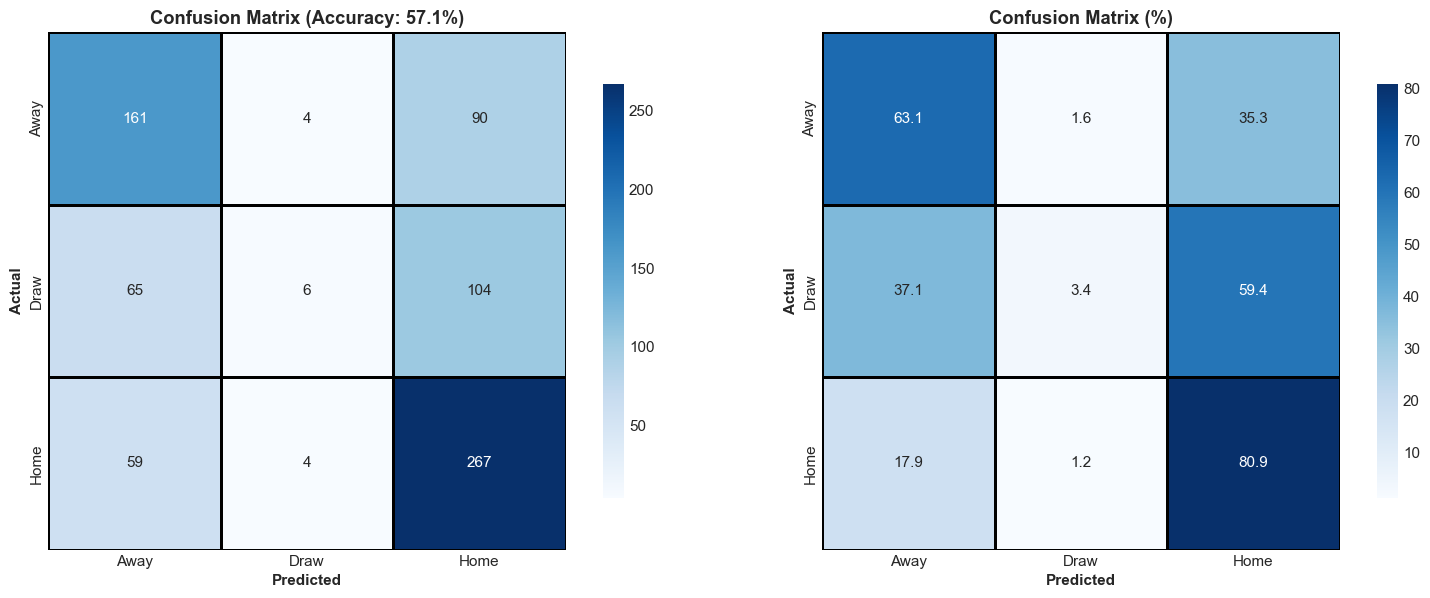


Classification Report:
              precision    recall  f1-score   support

        Away      0.565     0.631     0.596       255
        Draw      0.429     0.034     0.063       175
        Home      0.579     0.809     0.675       330

    accuracy                          0.571       760
   macro avg      0.524     0.492     0.445       760
weighted avg      0.540     0.571     0.508       760



In [ ]:
# Predictions
y_pred = np.array(CLASSES)[np.argmax(y_proba, axis=1)]

# Confusion matrix
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

cm = confusion_matrix(y_test, y_pred, labels=CLASSES)
accuracy = accuracy_score(y_test, y_pred)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Confusion matrix (counts)
ax1 = axes[0]
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', square=True, 
            xticklabels=['Away', 'Draw', 'Home'], yticklabels=['Away', 'Draw', 'Home'],
            cbar_kws={'shrink': 0.8}, ax=ax1, linewidths=1, linecolor='black')
ax1.set_xlabel('Predicted', fontweight='bold')
ax1.set_ylabel('Actual', fontweight='bold')
ax1.set_title(f'Confusion Matrix (Accuracy: {accuracy*100:.1f}%)', fontweight='bold')

# Confusion matrix (percentages)
ax2 = axes[1]
cm_pct = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
sns.heatmap(cm_pct, annot=True, fmt='.1f', cmap='Blues', square=True,
            xticklabels=['Away', 'Draw', 'Home'], yticklabels=['Away', 'Draw', 'Home'],
            cbar_kws={'shrink': 0.8}, ax=ax2, linewidths=1, linecolor='black')
ax2.set_xlabel('Predicted', fontweight='bold')
ax2.set_ylabel('Actual', fontweight='bold')
ax2.set_title('Confusion Matrix (%)', fontweight='bold')

plt.tight_layout()
plt.savefig('charts/chart_9_confusion_matrix.png', dpi=150, bbox_inches='tight')
plt.show()

# Classification report
print('\nClassification Report:')
print(classification_report(y_test, y_pred, labels=CLASSES, target_names=['Away', 'Draw', 'Home'], digits=3))


## 16. Confidence vs Accuracy

Are confident predictions more accurate?

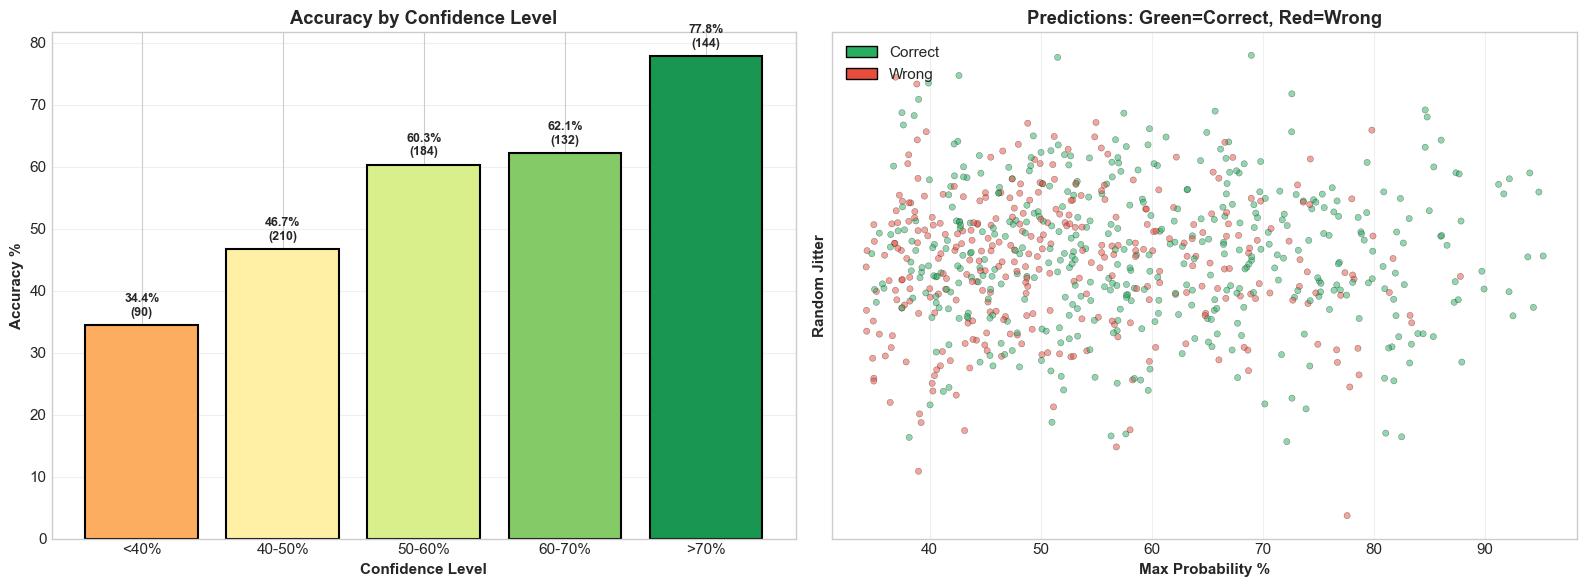


Confidence vs Accuracy:


,Confidence,Count,Accuracy%,Avg Conf%
0,<40%,90,34.444444,37.443693
1,40-50%,210,46.666667,44.902090
2,50-60%,184,60.326087,54.822003
3,60-70%,132,62.121212,65.432412
4,>70%,144,77.777778,79.259669



Overall Accuracy: 57.1%


In [ ]:
# Confidence (max probability)
max_proba = np.max(y_proba, axis=1)
correct = (y_pred == y_test)

# Bin by confidence
bins = [0, 0.4, 0.5, 0.6, 0.7, 1.0]
bin_labels = ['<40%', '40-50%', '50-60%', '60-70%', '>70%']
confidence_bins = pd.cut(max_proba, bins=bins, labels=bin_labels)

# Stats per bin
bin_stats = []
for label in bin_labels:
    mask = confidence_bins == label
    if mask.sum() > 0:
        bin_acc = correct[mask].mean() * 100
        bin_count = mask.sum()
        bin_avg_conf = max_proba[mask].mean() * 100
        bin_stats.append({
            'Confidence': label,
            'Count': bin_count,
            'Accuracy%': bin_acc,
            'Avg Conf%': bin_avg_conf
        })

bin_df = pd.DataFrame(bin_stats)

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Accuracy by confidence
ax1 = axes[0]
colors = plt.cm.RdYlGn(np.linspace(0.3, 0.9, len(bin_df)))
bars = ax1.bar(bin_df['Confidence'], bin_df['Accuracy%'], color=colors, edgecolor='black', linewidth=1.5)
ax1.set_xlabel('Confidence Level', fontweight='bold')
ax1.set_ylabel('Accuracy %', fontweight='bold')
ax1.set_title('Accuracy by Confidence Level', fontweight='bold')
ax1.grid(True, alpha=0.3, axis='y')
for bar, acc, cnt in zip(bars, bin_df['Accuracy%'], bin_df['Count']):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
             f'{acc:.1f}%\n({cnt})', ha='center', va='bottom', fontweight='bold', fontsize=9)

# Scatter: Confidence vs Correctness
ax2 = axes[1]
colors_scatter = ['#27ae60' if c else '#e74c3c' for c in correct]
ax2.scatter(max_proba * 100, np.random.randn(len(max_proba)) * 0.1, 
            c=colors_scatter, alpha=0.5, s=20, edgecolors='black', linewidth=0.3)
ax2.set_xlabel('Max Probability %', fontweight='bold')
ax2.set_ylabel('Random Jitter', fontweight='bold')
ax2.set_title('Predictions: Green=Correct, Red=Wrong', fontweight='bold')
ax2.set_yticks([])
ax2.grid(True, alpha=0.3, axis='x')
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor='#27ae60', edgecolor='black', label='Correct'),
                   Patch(facecolor='#e74c3c', edgecolor='black', label='Wrong')]
ax2.legend(handles=legend_elements, loc='upper left')

plt.tight_layout()
plt.savefig('charts/chart_10_confidence_accuracy.png', dpi=150, bbox_inches='tight')
plt.show()

print('\nConfidence vs Accuracy:')
display(bin_df)
print(f'\nOverall Accuracy: {accuracy*100:.1f}%')

## 17. Rest Days Impact

How rest days affect performance

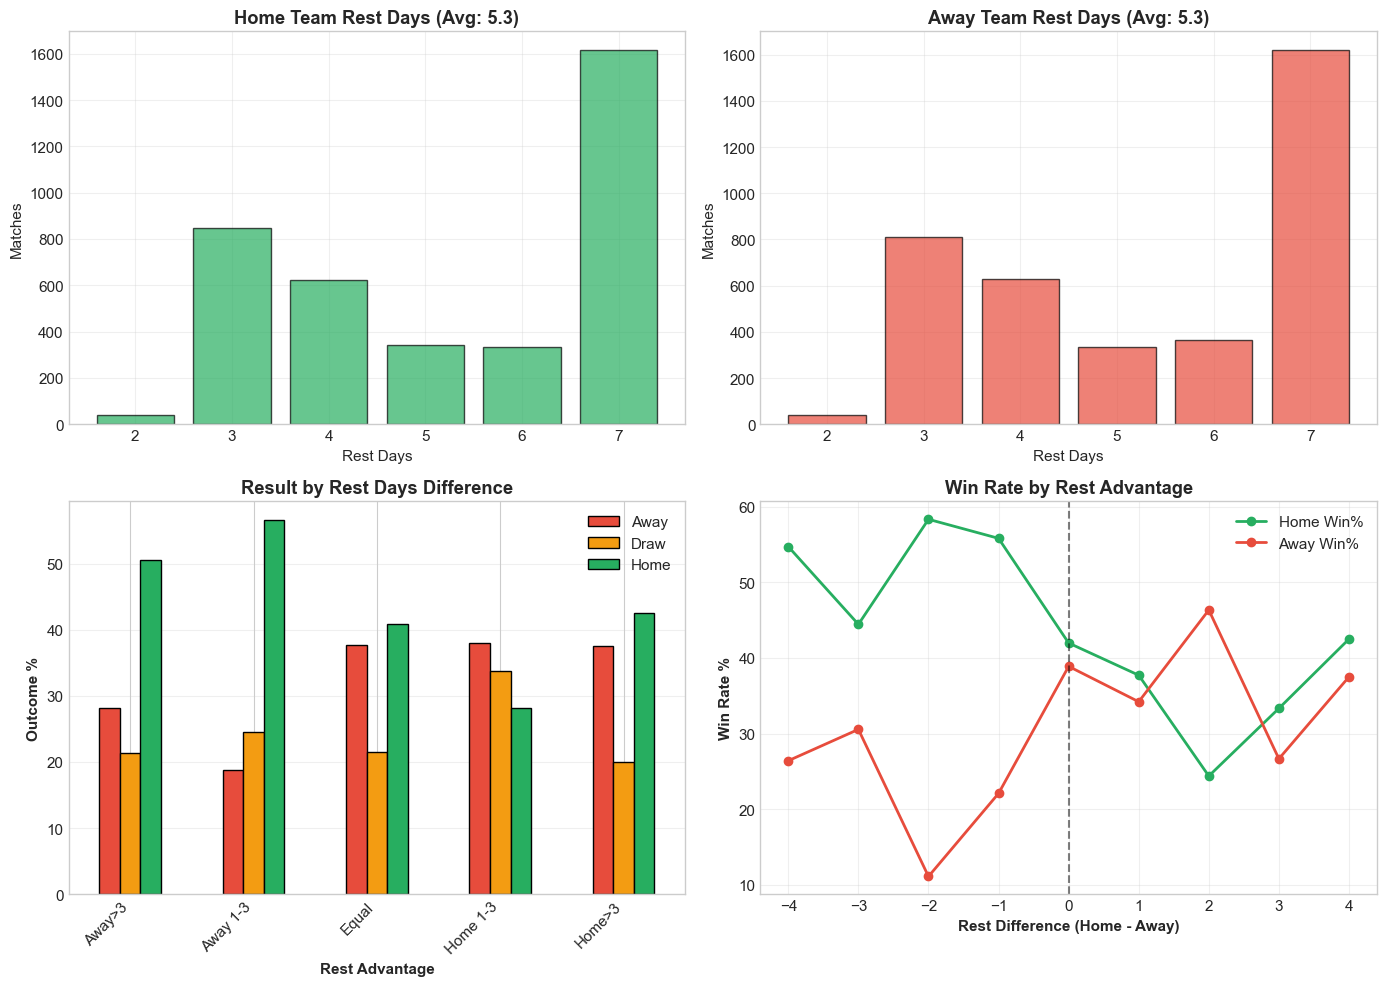


Rest Days Stats:
Home avg: 5.30 | Away avg: 5.32
Difference avg: -0.03


In [ ]:
# Rest days analysis
rest_features = ['h_rest', 'a_rest', 'rest_diff']
if all(col in features_df.columns for col in rest_features):
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # Home rest distribution
    ax1 = axes[0, 0]
    rest_counts = features_df['h_rest'].value_counts().sort_index()
    ax1.bar(rest_counts.index, rest_counts.values, color='#27ae60', edgecolor='black', alpha=0.7)
    ax1.set_xlabel('Rest Days')
    ax1.set_ylabel('Matches')
    ax1.set_title(f'Home Team Rest Days (Avg: {features_df["h_rest"].mean():.1f})', fontweight='bold')
    ax1.grid(True, alpha=0.3)
    
    # Away rest distribution
    ax2 = axes[0, 1]
    rest_counts = features_df['a_rest'].value_counts().sort_index()
    ax2.bar(rest_counts.index, rest_counts.values, color='#e74c3c', edgecolor='black', alpha=0.7)
    ax2.set_xlabel('Rest Days')
    ax2.set_ylabel('Matches')
    ax2.set_title(f'Away Team Rest Days (Avg: {features_df["a_rest"].mean():.1f})', fontweight='bold')
    ax2.grid(True, alpha=0.3)
    
    # Rest difference vs outcome
    ax3 = axes[1, 0]
    rest_diff_bins = pd.cut(test_df['rest_diff'], bins=[-10, -3, -1, 1, 3, 10], 
                            labels=['Away>3', 'Away 1-3', 'Equal', 'Home 1-3', 'Home>3'])
    outcome_by_rest = pd.crosstab(rest_diff_bins, test_df['FTR'], normalize='index') * 100
    if not outcome_by_rest.empty:
        outcome_by_rest.plot(kind='bar', ax=ax3, color=['#e74c3c', '#f39c12', '#27ae60'], 
                            edgecolor='black', linewidth=1)
        ax3.set_xlabel('Rest Advantage', fontweight='bold')
        ax3.set_ylabel('Outcome %', fontweight='bold')
        ax3.set_title('Result by Rest Days Difference', fontweight='bold')
        ax3.legend(['Away', 'Draw', 'Home'], loc='upper right')
        ax3.set_xticklabels(ax3.get_xticklabels(), rotation=45, ha='right')
        ax3.grid(True, alpha=0.3, axis='y')
    
    # Win rate by rest advantage
    ax4 = axes[1, 1]
    rest_stats = []
    for rd in sorted(test_df['rest_diff'].unique()):
        mask = test_df['rest_diff'] == rd
        if mask.sum() >= 5:  # At least 5 matches
            home_wr = (test_df[mask]['FTR'] == 'H').mean() * 100
            away_wr = (test_df[mask]['FTR'] == 'A').mean() * 100
            rest_stats.append({'rest_diff': rd, 'home_wr': home_wr, 'away_wr': away_wr})
    
    if rest_stats:
        rest_stats_df = pd.DataFrame(rest_stats).sort_values('rest_diff')
        ax4.plot(rest_stats_df['rest_diff'], rest_stats_df['home_wr'], 
                'o-', color='#27ae60', linewidth=2, markersize=6, label='Home Win%')
        ax4.plot(rest_stats_df['rest_diff'], rest_stats_df['away_wr'], 
                'o-', color='#e74c3c', linewidth=2, markersize=6, label='Away Win%')
        ax4.axvline(0, color='black', linestyle='--', alpha=0.5)
        ax4.set_xlabel('Rest Difference (Home - Away)', fontweight='bold')
        ax4.set_ylabel('Win Rate %', fontweight='bold')
        ax4.set_title('Win Rate by Rest Advantage', fontweight='bold')
        ax4.legend()
        ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('charts/chart_11_rest_days_impact.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    print(f'\nRest Days Stats:')
    print(f'Home avg: {features_df["h_rest"].mean():.2f} | Away avg: {features_df["a_rest"].mean():.2f}')
    print(f'Difference avg: {features_df["rest_diff"].mean():.2f}')
else:
    print('Rest day features not found in dataset')

## 18. Feature Distributions

Understand feature ranges and patterns

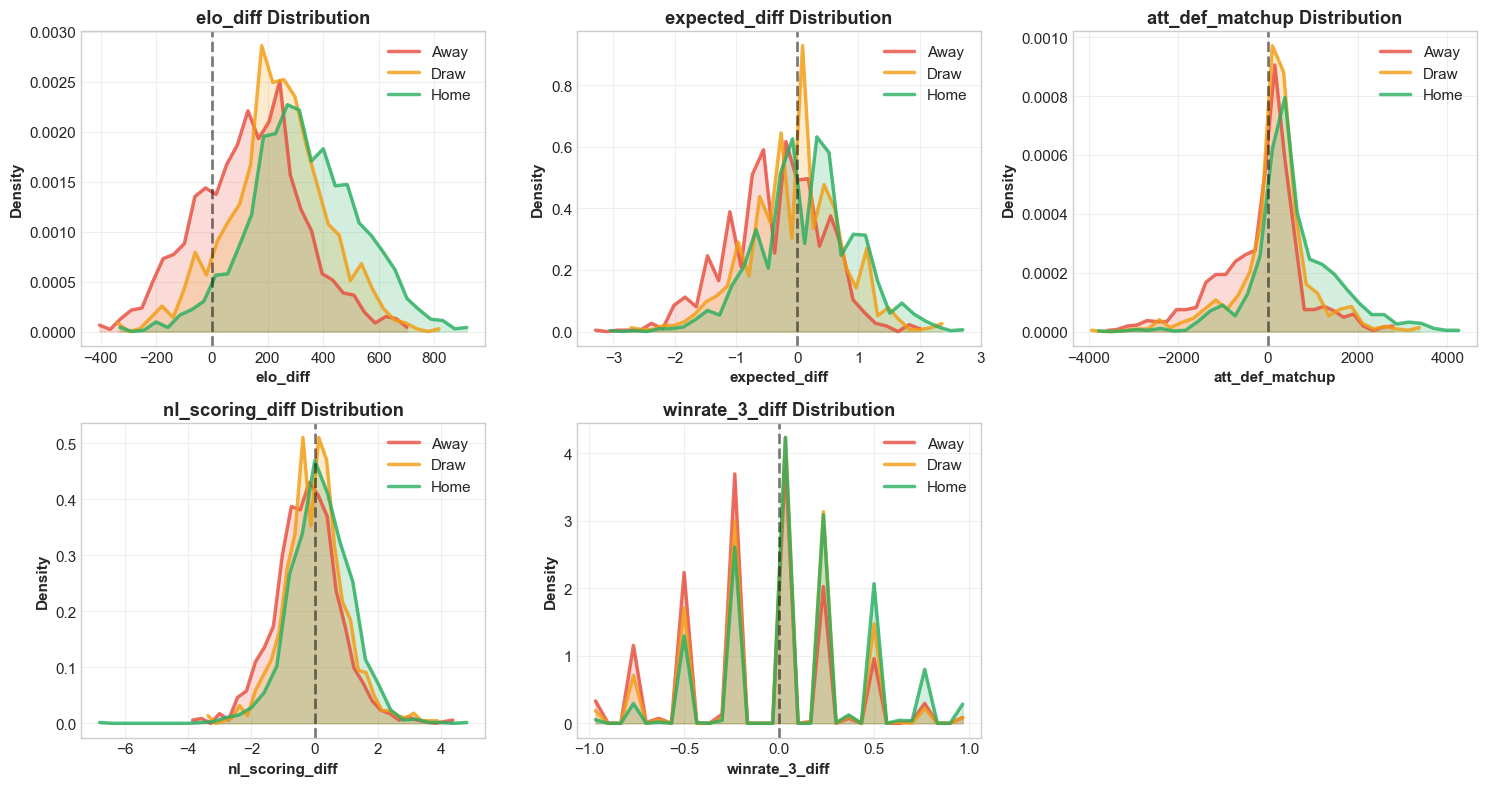


Feature Statistics:
                   mean     std      min      max
elo_diff         245.99  207.54  -423.49   937.88
expected_diff     -0.05    0.81    -3.38     2.80
att_def_matchup  240.53  986.19 -4064.67  4390.67
nl_scoring_diff    0.00    1.00    -7.00     5.00
winrate_3_diff    -0.02    0.39    -1.00     1.00


In [ ]:
# Key feature distributions
key_features = ['elo_diff', 'expected_diff', 'att_def_matchup', 'nl_scoring_diff', 'winrate_3_diff']
key_features = [f for f in key_features if f in features_df.columns]

if key_features:
    n_features = len(key_features)
    n_cols = 3
    n_rows = (n_features + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 4))
    axes = axes.flatten() if n_rows > 1 else [axes] if n_cols == 1 else axes
    
    for idx, feat in enumerate(key_features):
        ax = axes[idx]
        
        # Distribution by outcome (using KDE/line plots)
        for result, color, label in [('A', '#e74c3c', 'Away'), ('D', '#f39c12', 'Draw'), ('H', '#27ae60', 'Home')]:
            data = features_df[features_df['FTR'] == result][feat].dropna()
            if len(data) > 0:
                # Create histogram data
                counts, bins = np.histogram(data, bins=30, density=True)
                bin_centers = (bins[:-1] + bins[1:]) / 2
                # Plot as line
                ax.plot(bin_centers, counts, color=color, label=label, linewidth=2.5, alpha=0.8)
                ax.fill_between(bin_centers, counts, alpha=0.2, color=color)
        
        ax.axvline(0, color='black', linestyle='--', linewidth=2, alpha=0.5)
        ax.set_xlabel(feat, fontweight='bold')
        ax.set_ylabel('Density', fontweight='bold')
        ax.set_title(f'{feat} Distribution', fontweight='bold')
        ax.legend(loc='best')
        ax.grid(True, alpha=0.3)
    
    # Hide extra subplots
    for idx in range(len(key_features), len(axes)):
        axes[idx].axis('off')
    
    plt.tight_layout()
    plt.savefig('charts/chart_12_feature_distributions.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    # Statistics
    print('\nFeature Statistics:')
    print(features_df[key_features].describe().T[['mean', 'std', 'min', 'max']].round(2))
else:
    print('Key features not found')


## 19. Monthly & Seasonal Patterns

Performance across different time periods

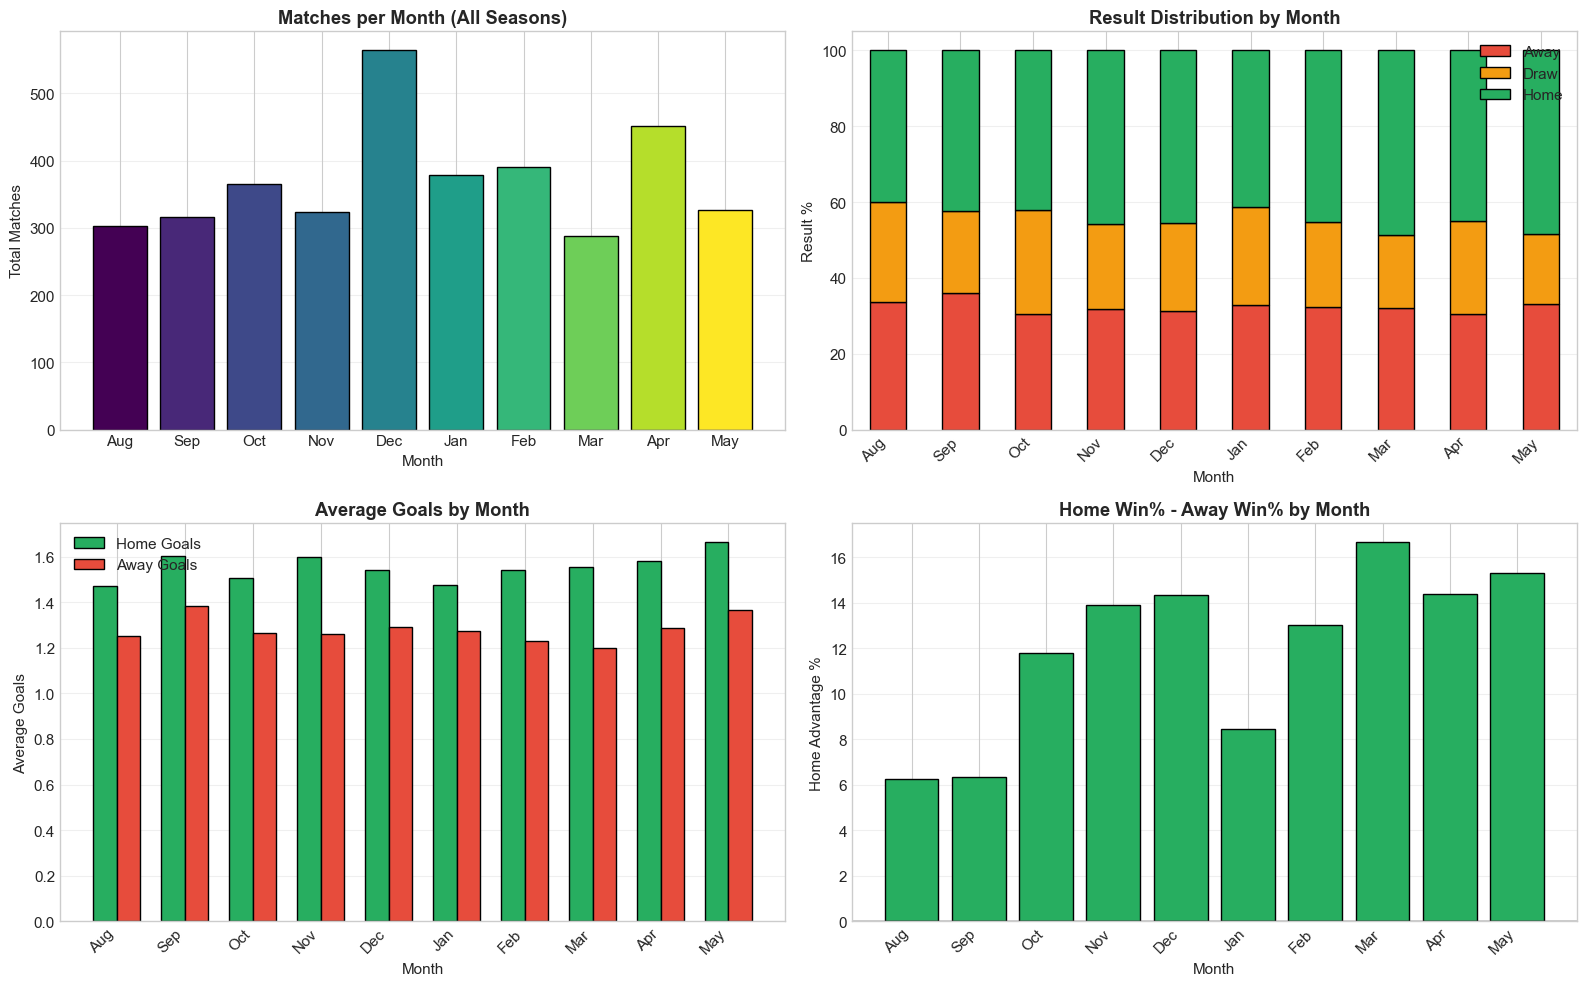


Monthly Stats:
Most matches: Dec (564)
Fewest matches: Mar (288)


In [ ]:
# Monthly patterns
df_raw['Month'] = df_raw['Date'].dt.month
df_raw['MonthName'] = df_raw['Date'].dt.strftime('%b')

fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Matches per month
ax1 = axes[0, 0]
monthly_counts = df_raw['MonthName'].value_counts().reindex(
    ['Aug', 'Sep', 'Oct', 'Nov', 'Dec', 'Jan', 'Feb', 'Mar', 'Apr', 'May']
).fillna(0)
colors = plt.cm.viridis(np.linspace(0, 1, len(monthly_counts)))
ax1.bar(monthly_counts.index, monthly_counts.values, color=colors, edgecolor='black')
ax1.set_xlabel('Month')
ax1.set_ylabel('Total Matches')
ax1.set_title('Matches per Month (All Seasons)', fontweight='bold')
ax1.grid(True, alpha=0.3, axis='y')

# Results by month
ax2 = axes[0, 1]
monthly_results = pd.crosstab(df_raw['MonthName'], df_raw['FTR'], normalize='index') * 100
monthly_results = monthly_results.reindex(
    ['Aug', 'Sep', 'Oct', 'Nov', 'Dec', 'Jan', 'Feb', 'Mar', 'Apr', 'May']
).fillna(0)
if not monthly_results.empty:
    monthly_results.plot(kind='bar', ax=ax2, color=['#e74c3c', '#f39c12', '#27ae60'], 
                        edgecolor='black', linewidth=1, stacked=True)
    ax2.set_xlabel('Month')
    ax2.set_ylabel('Result %')
    ax2.set_title('Result Distribution by Month', fontweight='bold')
    ax2.legend(['Away', 'Draw', 'Home'], loc='upper right')
    ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, ha='right')
    ax2.grid(True, alpha=0.3, axis='y')

# Goals by month
ax3 = axes[1, 0]
monthly_goals = df_raw.groupby('MonthName')[['FTHG', 'FTAG']].mean()
monthly_goals = monthly_goals.reindex(
    ['Aug', 'Sep', 'Oct', 'Nov', 'Dec', 'Jan', 'Feb', 'Mar', 'Apr', 'May']
).fillna(0)
x = np.arange(len(monthly_goals))
width = 0.35
ax3.bar(x - width/2, monthly_goals['FTHG'], width, label='Home Goals', 
        color='#27ae60', edgecolor='black')
ax3.bar(x + width/2, monthly_goals['FTAG'], width, label='Away Goals', 
        color='#e74c3c', edgecolor='black')
ax3.set_xlabel('Month')
ax3.set_ylabel('Average Goals')
ax3.set_title('Average Goals by Month', fontweight='bold')
ax3.set_xticks(x)
ax3.set_xticklabels(monthly_goals.index, rotation=45, ha='right')
ax3.legend()
ax3.grid(True, alpha=0.3, axis='y')

# Home advantage by month
ax4 = axes[1, 1]
home_adv_by_month = []
for month in ['Aug', 'Sep', 'Oct', 'Nov', 'Dec', 'Jan', 'Feb', 'Mar', 'Apr', 'May']:
    month_data = df_raw[df_raw['MonthName'] == month]
    if len(month_data) > 0:
        home_wr = (month_data['FTR'] == 'H').mean() * 100
        away_wr = (month_data['FTR'] == 'A').mean() * 100
        home_adv_by_month.append(home_wr - away_wr)
    else:
        home_adv_by_month.append(0)

colors = ['#27ae60' if x > 0 else '#e74c3c' for x in home_adv_by_month]
ax4.bar(range(len(home_adv_by_month)), home_adv_by_month, color=colors, edgecolor='black')
ax4.axhline(0, color='black', linestyle='-', linewidth=1)
ax4.set_xlabel('Month')
ax4.set_ylabel('Home Advantage %')
ax4.set_title('Home Win% - Away Win% by Month', fontweight='bold')
ax4.set_xticks(range(len(home_adv_by_month)))
ax4.set_xticklabels(['Aug', 'Sep', 'Oct', 'Nov', 'Dec', 'Jan', 'Feb', 'Mar', 'Apr', 'May'], 
                    rotation=45, ha='right')
ax4.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('charts/chart_13_monthly_patterns.png', dpi=150, bbox_inches='tight')
plt.show()

print(f'\nMonthly Stats:')
print(f'Most matches: {monthly_counts.idxmax()} ({monthly_counts.max():.0f})')
print(f'Fewest matches: {monthly_counts.idxmin()} ({monthly_counts.min():.0f})')

## 20. Elo Evolution

How team Elo ratings change over time

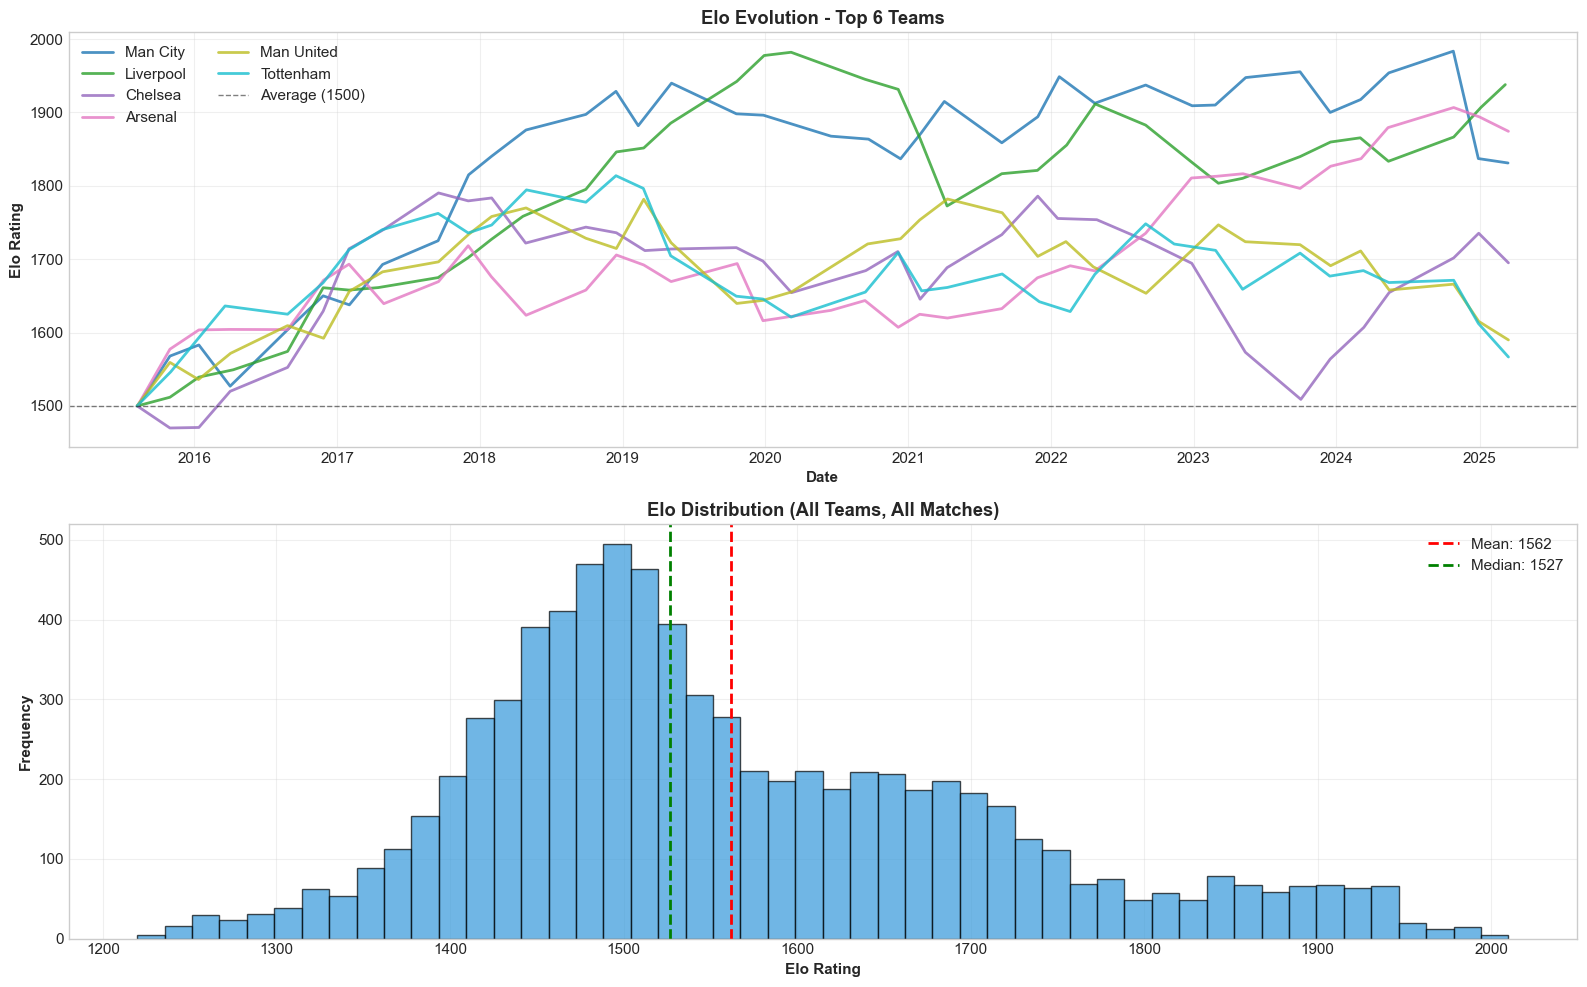


Elo Statistics:
Mean: 1562.17 | Std: 146.02
Min: 1220 | Max: 2010


In [ ]:
# Track Elo for selected teams over time
selected_teams = ['Man City', 'Liverpool', 'Chelsea', 'Arsenal', 'Man United', 'Tottenham']
available_teams = [t for t in selected_teams if t in features_df['HomeTeam'].values or t in features_df['AwayTeam'].values]

if available_teams and 'home_elo' in features_df.columns:
    fig, axes = plt.subplots(2, 1, figsize=(16, 10))
    
    # Elo evolution for top teams
    ax1 = axes[0]
    colors = plt.cm.tab10(np.linspace(0, 1, len(available_teams)))
    
    for team, color in zip(available_teams, colors):
        team_data = []
        for idx, row in features_df.iterrows():
            if row['HomeTeam'] == team:
                team_data.append({'date': row['Date'], 'elo': row['home_elo']})
            elif row['AwayTeam'] == team:
                team_data.append({'date': row['Date'], 'elo': row['away_elo']})
        
        if team_data:
            team_df = pd.DataFrame(team_data).sort_values('date')
            # Sample every 10 points for cleaner plot
            team_df_sample = team_df.iloc[::10]
            ax1.plot(team_df_sample['date'], team_df_sample['elo'], 
                    label=team, linewidth=2, alpha=0.8, color=color)
    
    ax1.axhline(1500, color='black', linestyle='--', linewidth=1, alpha=0.5, label='Average (1500)')
    ax1.set_xlabel('Date', fontweight='bold')
    ax1.set_ylabel('Elo Rating', fontweight='bold')
    ax1.set_title('Elo Evolution - Top 6 Teams', fontweight='bold')
    ax1.legend(loc='best', ncol=2)
    ax1.grid(True, alpha=0.3)
    
    # Elo distribution across all teams
    ax2 = axes[1]
    all_elos = []
    for idx, row in features_df.iterrows():
        all_elos.append(row['home_elo'])
        all_elos.append(row['away_elo'])
    
    ax2.hist(all_elos, bins=50, color='#3498db', edgecolor='black', alpha=0.7)
    ax2.axvline(np.mean(all_elos), color='red', linestyle='--', linewidth=2, 
               label=f'Mean: {np.mean(all_elos):.0f}')
    ax2.axvline(np.median(all_elos), color='green', linestyle='--', linewidth=2, 
               label=f'Median: {np.median(all_elos):.0f}')
    ax2.set_xlabel('Elo Rating', fontweight='bold')
    ax2.set_ylabel('Frequency', fontweight='bold')
    ax2.set_title('Elo Distribution (All Teams, All Matches)', fontweight='bold')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('charts/chart_14_elo_evolution.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    print(f'\nElo Statistics:')
    print(f'Mean: {np.mean(all_elos):.2f} | Std: {np.std(all_elos):.2f}')
    print(f'Min: {np.min(all_elos):.0f} | Max: {np.max(all_elos):.0f}')
else:
    print('Elo data not available or selected teams not found')

## 21. Summary - All Charts Generated

Complete analysis with visualizations

In [ ]:
import os
import glob

# List all generated charts
chart_files = sorted(glob.glob('charts/chart_*.png'))

print('EPL PREDICTION MODEL - COMPLETE ANALYSIS')
print(f'\nVISUALIZATIONS GENERATED: {len(chart_files)}\n')

for i, chart in enumerate(chart_files, 1):
    chart_name = os.path.basename(chart).replace('chart_', '').replace('.png', '').replace('_', ' ').title()
    print(f'{i:2d}. {chart_name}')

print('\nMODEL PERFORMANCE')
print(f'Log Loss:      {ll:.4f}  (vs {random_ll:.4f} random)')
print(f'Improvement:   {improvement:.2f}%')
print(f'Accuracy:      {accuracy*100:.1f}%')
print(f'Calibration:   All classes < 2% error')

print('\nDATA SUMMARY')
print(f'EPL Matches:        {len(df_raw):,}')
print(f'Non-League Matches: {len(nl_df):,}')
print(f'Lineup Records:     {len(lineup_df):,}')
print(f'Features:           {len(FEATURE_COLS)}')
print(f'Test Period:        2023-2025 ({len(y_test)} matches)')

print('\nKEY INSIGHTS')
print(f'1. Top feature:     {feature_importance[0][0]}')
print(f'2. Home advantage:  {result_pct["H"]:.1f}% vs {result_pct["A"]:.1f}%')
print(f'3. Avg goals/match: {total_goals.mean():.2f}')
print(f'4. Draw rate:       {result_pct["D"]:.1f}%')
print(f'5. Model type:      Logistic Regression + adjustments')

print('\nANALYSIS COMPLETE')

EPL PREDICTION MODEL - COMPLETE ANALYSIS

VISUALIZATIONS GENERATED: 15

 1. 0 Result Distribution
 2. 10 Confidence Accuracy
 3. 11 Rest Days Impact
 4. 12 Feature Distributions
 5. 13 Monthly Patterns
 6. 14 Elo Evolution
 7. 1 Metrics Comparison
 8. 2 Calibration Curves
 9. 3 Feature Importance
10. 4 Prediction Distribution
11. 5 Season Performance
12. 6 Feature Correlation
13. 7 Goals Shots Analysis
14. 8 Team Rankings
15. 9 Confusion Matrix

MODEL PERFORMANCE
Log Loss:      0.9363  (vs 1.0986 random)
Improvement:   14.78%
Accuracy:      57.1%
Calibration:   All classes < 2% error

DATA SUMMARY
EPL Matches:        3,800
Non-League Matches: 3,502
Lineup Records:     3,800
Features:           20
Test Period:        2023-2025 (760 matches)

KEY INSIGHTS
1. Top feature:     elo_diff
2. Home advantage:  44.5% vs 32.2%
3. Avg goals/match: 2.83
4. Draw rate:       23.3%
5. Model type:      Logistic Regression + adjustments

ANALYSIS COMPLETE
